# K9 signal 5 tissue

In [4]:
import subprocess
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [5]:
def get_bigwig_mean(bw_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bw_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold


def scan_bw_signal_split2bins(bw_scan, name, capture_regions_file, bigwig_files, labels, resolution=100, left_span=2000, right_span=2000, origin_len = 1) :
    cmd = f'''awk '{{print $1"\\t"$2-{left_span}-{resolution >> 1}"\\t"$3+{right_span}+{resolution >> 1}"\\t"$4"\\t"$5"\\t"$6}}' {capture_regions_file} > capture_regions.bed '''
    print(subprocess.check_output(cmd, shell=True).decode(), end='')
    
    capture_points = int((left_span + right_span) / resolution + 1) if (left_span+right_span) > 0 else int(origin_len / resolution + 1)
    capture_regions_file = 'capture_regions.bed'
    bw_scan_cmd = f'/mnt/Storage/home/wangyiman/bin/utilities/getBigWigValue.py -n {name} -p 8 -s {capture_points} -m speed -b {capture_regions_file}'

    for bigwig_file in bigwig_files:
        bw_scan_cmd += f' -w {bigwig_file}'
    
    if bw_scan:
        print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')

    xticks = np.arange(-left_span, right_span + resolution, resolution) if (left_span+right_span) > 0 else np.arange(0, origin_len + resolution, resolution)
    signal = {}
    for index, (bigwig_file, label) in enumerate(zip(bigwig_files, labels)):
        mean = get_bigwig_mean(bigwig_file)
        signal[label] = pd.read_csv(f'signal_{name}_siteprof{index+1}.gz',
                                    sep='\t',
                                    header=None,
                                    index_col=None,
                                    names=xticks) / mean     
    return signal

In [10]:
stage_dict = {
    'EarlyEmbryogenesis': ['2cell','8cell','Morula','ICM',],
    'PGCsDevelopment': ['E10.5','E13.5_female','E13.5_male',],
    'Spermatogenesis': ['US','DS','PS','RS',],
    'RetinalDevelopment': ['E14.5','E17.5','P0','P3','P7','P10','P14','P21',],
    'HeartDevelopment': ['E10.5','E11.5','E12.5','E13.5','E14.5','E15.5','E16.5','P0',],
    'LiverDevelopment': ['E11.5','E12.5','E13.5','E14.5','E15.5','E16.5','P0']
}

In [12]:
os.chdir('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue/CHM_intersect_table/')
signal_AB_dict = {}
for end in ['5end', '3end', 'body'] :
    signal_AB_dict[end] = {}
    for compart in ['A', 'B'] :
        bed_fi = f'intersectOnly_UniversalCHM_5tissue_{compart}.{end}.bed' if end != 'body' else f'intersectOnly_UniversalCHM_5tissue_{compart}.bed'
        bw_scan = True if end != '5end' else True
#             resolution = 100 if end == 'body' else 500
        left_span = 0 if end != '5end' else 100000
        right_span = 0 if end != '3end' else 100000
        origin_len = 0 if end != 'body' else 5000 # average Universal CHM length
        signal_AB_dict[end][compart] = scan_bw_signal_split2bins(
            bw_scan = bw_scan,
            name = f'K9_around_CHM_{compart}_{end}',
            capture_regions_file = bed_fi,
            resolution = 100,
            left_span = left_span,
            right_span = right_span,
            origin_len = origin_len,
            bigwig_files = [f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/MethK9Signal/{process}_{stage}.H3K9me3.rmDup.bw' for process in stage_dict.keys() for stage in stage_dict[process]],
            labels = [f'{process}_{stage}_H3K9me3' for process in stage_dict.keys() for stage in stage_dict[process]],
        )

In [13]:
signal_AB_concat_dict = {}
# for span in [5000, 10000, 50000, 100000, 500000, 1000000, 2000000] :
for span in [50000, 100000] :
    signal_AB_concat_dict[span] = {}
    for i,label in enumerate([f'{process}_{stage}_H3K9me3' for process in stage_dict.keys() for stage in stage_dict[process]]) :        
        signal_AB_concat_dict[span][label] = {}
        for compart in ['A', 'B'] :
            signal_AB_concat_dict[span][label][compart] = pd.concat([signal_AB_dict['5end'][compart][label][np.arange(-span, 0, 100)], 
                                                                                signal_AB_dict['body'][compart][label], 
                                                                                signal_AB_dict['3end'][compart][label][np.arange(100, span+100, 100)]], axis = 1)
            body_len = signal_AB_dict['body'][compart][label].columns[-1] - signal_AB_dict['body'][compart][label].columns[0]
            signal_AB_concat_dict[span][label][compart].columns = np.arange(-span, 0, 100).tolist() + signal_AB_dict['body'][compart][label].columns.tolist() + (np.arange(100, span+100, 100) + body_len).tolist() 
    
signal_AB_concat_dict[span][label][compart]

,-100000,-99900,-99800,-99700,-99600,-99500,-99400,-99300,-99200,-99100,...,104100,104200,104300,104400,104500,104600,104700,104800,104900,105000
0,1.222536,0.660323,0.776326,0.891054,0.763578,0.758479,0.643751,1.129433,1.483925,1.281148,...,2.372451,2.389028,2.071611,1.942864,1.851073,1.649670,1.801368,2.032097,1.559165,1.524779
1,2.095834,1.988752,1.568070,1.411269,1.666234,1.718509,1.540030,1.687913,2.062693,2.522877,...,1.436764,1.472463,1.709578,2.224582,2.767625,2.276844,2.349513,3.559272,3.315770,3.652776
2,2.111126,1.532358,1.309234,1.392121,1.654772,1.946680,1.487768,1.089921,1.356409,1.803913,...,0.987935,0.446164,0.316139,0.610608,0.883405,0.699841,0.309766,0.430867,0.610608,0.773688
3,0.000000,0.000000,0.026770,0.193763,0.495880,1.115419,1.693014,2.327834,2.564936,1.947965,...,0.647576,1.255673,2.125146,2.139179,1.460974,1.245472,1.527283,1.557880,1.811558,1.806243
4,1.004507,0.843888,0.952242,0.860460,1.019819,1.838326,1.616502,0.945868,1.574417,1.965801,...,1.692961,1.551506,2.250077,2.287048,2.176136,2.098378,2.211834,1.805185,1.394679,1.413693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,0.006374,0.247303,0.571090,1.188119,1.325812,0.823492,0.518825,0.271523,0.724061,1.186797,...,2.380097,2.999638,2.805868,2.174864,1.741447,2.004044,1.913539,2.241159,3.124556,2.634204
942,0.000000,0.000000,0.067562,0.360756,0.537947,0.404097,0.159344,0.014022,0.558343,0.980287,...,0.000000,0.349283,0.518825,0.342909,0.750831,1.069520,0.792898,0.718962,0.693467,0.705533
943,0.863009,0.678170,0.808195,0.416845,0.508627,0.739358,0.625905,0.539221,0.769952,0.740633,...,1.670023,1.760568,2.122601,2.302339,2.204188,1.555309,1.351308,0.975188,0.604234,0.697961
944,1.040200,1.292650,1.371728,1.707034,1.524712,1.200874,1.313041,1.884228,1.977277,1.274794,...,0.580014,0.744457,0.500979,0.605509,1.255677,1.241620,0.820942,0.815843,0.972638,1.312659


In [14]:
color_dict = {
    'EarlyEmbryogenesis': ['#9B1C3D', '#E8809B'],
    'PGCsDevelopment': ['#16557A', '#7EC1E8'],
    'Spermatogenesis': '#1B9E77',
    'RetinalDevelopment': '#BF8B12',
    'HeartDevelopment': '#2E8BC0',
    'LiverDevelopment': '#666666'
}

In [15]:
colors = ['#C490C6', '#90ADC6']

In [16]:
12 * 16 + 4

196

In [17]:
stage_3_dict = {
 'EarlyEmbryogenesis': ['2cell', '8cell', 'ICM'],
 'PGCsDevelopment': ['E10.5', 'E13.5_female', 'E13.5_male'],
 'Spermatogenesis': ['US', 'DS', 'RS'],
 'RetinalDevelopment': ['E14.5', 'P0', 'P21'],
 'HeartDevelopment': ['E10.5', 'E13.5', 'P0'],
 'LiverDevelopment': ['E11.5', 'E14.5', 'P0']
}

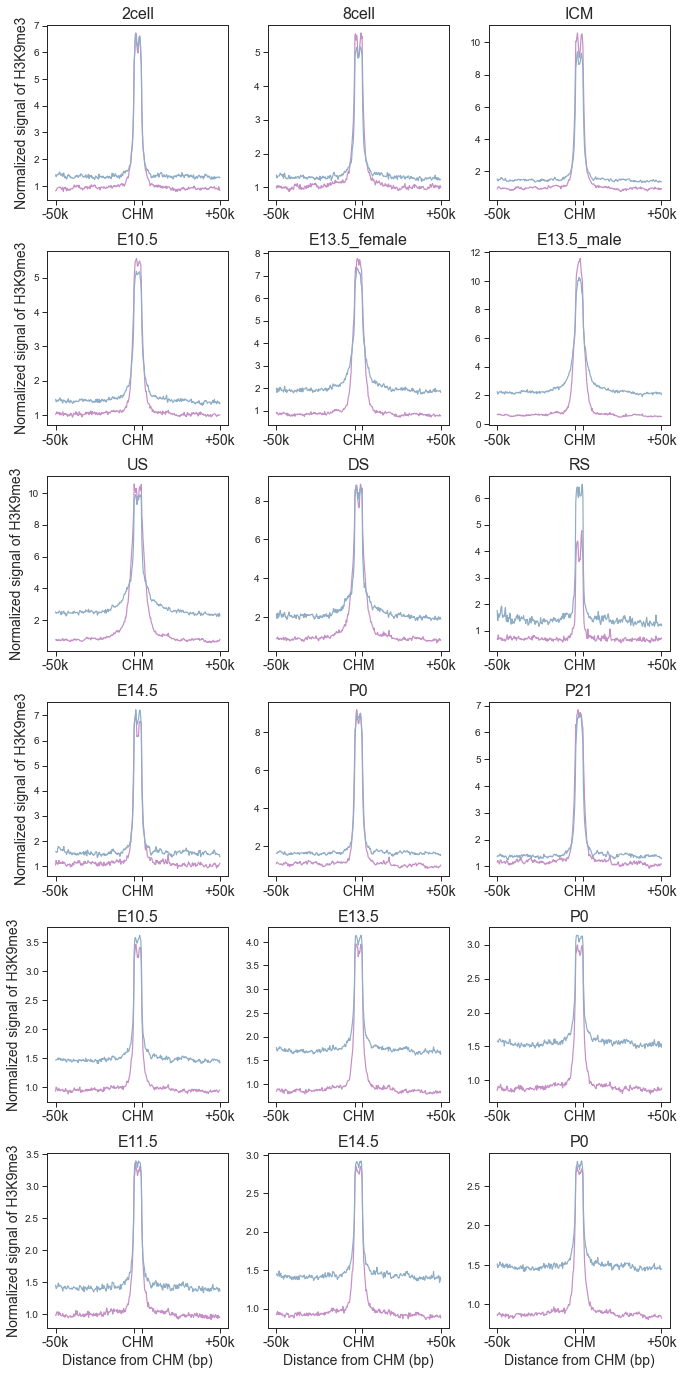

In [18]:
from scipy.interpolate import make_interp_spline, BSpline
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 16,
                             'axes.labelsize': 14,
                             'xtick.labelsize': 14,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 8
                         }):
    
    for span in [50000] :    
        fig, axes = plt.subplots(6, 3, figsize=(6.4 * 1.5, 4.8 * 4), sharey = False, sharex = False, tight_layout = True)  
        for a,process in enumerate(stage_dict.keys()) :
            for b,stage in enumerate(stage_3_dict[process]) : 
                ax = axes[a, b]
                label = f'{process}_{stage}_H3K9me3'
                for j,compart in enumerate(['A', 'B']) :
                    x = signal_AB_concat_dict[span][label][compart].columns
                    xnew = np.linspace(x.min(), x.max(), 300) 
                    spl = make_interp_spline(x, signal_AB_concat_dict[span][label][compart].mean(), k = 3)
                    signal_smooth = spl(xnew)
                    ax.plot(xnew, signal_smooth, label=compart, color=colors[j])

#                     h, l = ax.get_legend_handles_labels()
#                     if a == 0 and b == 0 :
#                         ax.legend(h, ['A', 'B'], title='Compartment')

                ax.set_xticks([-span, 0, 5000, 5000+span])
                ax.set_xticklabels([f'-{str(span)[:-3]}k', "  CHM", "", f"+{str(span)[:-3]}k"])

                if a == (len(stage_dict.keys()) - 1) :
                    ax.set_xlabel('Distance from CHM (bp)')

                if b == 0 :
                    ax.set_ylabel('Normalized signal of H3K9me3')
                ax.set_title(f'{stage}')

        fig.savefig(f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make13_line_K9_3stages_UniversalCHM_overlap_ABcompart_{str(span)[:-3]}k_5tissue_consistent.pdf', transparent=True)        


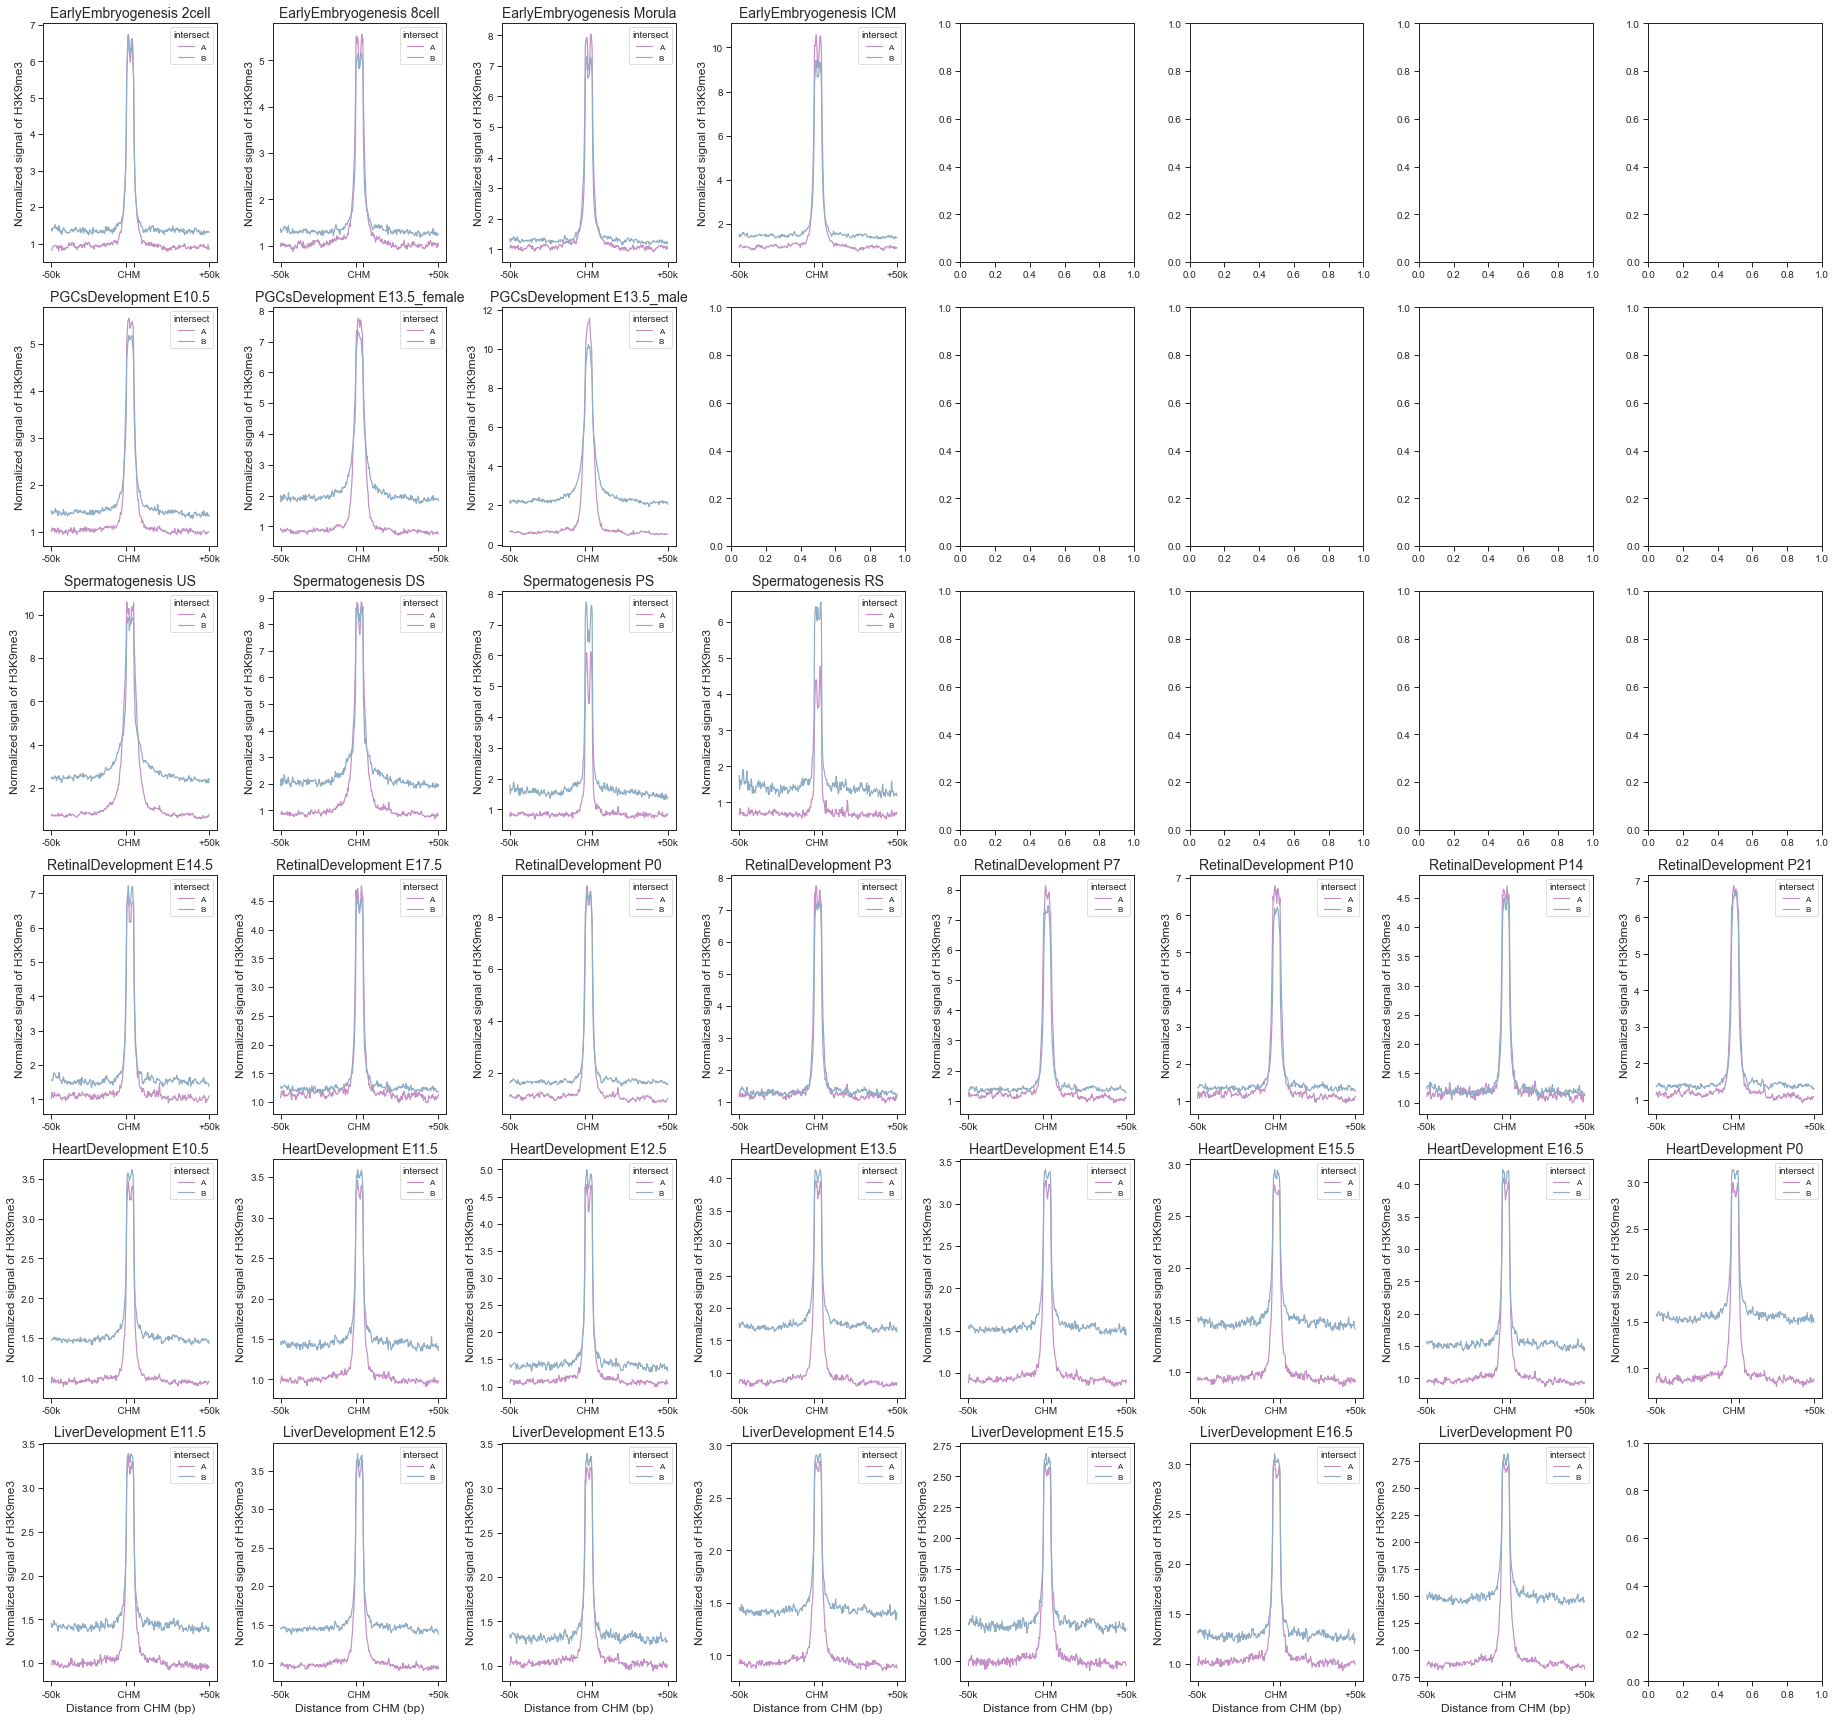

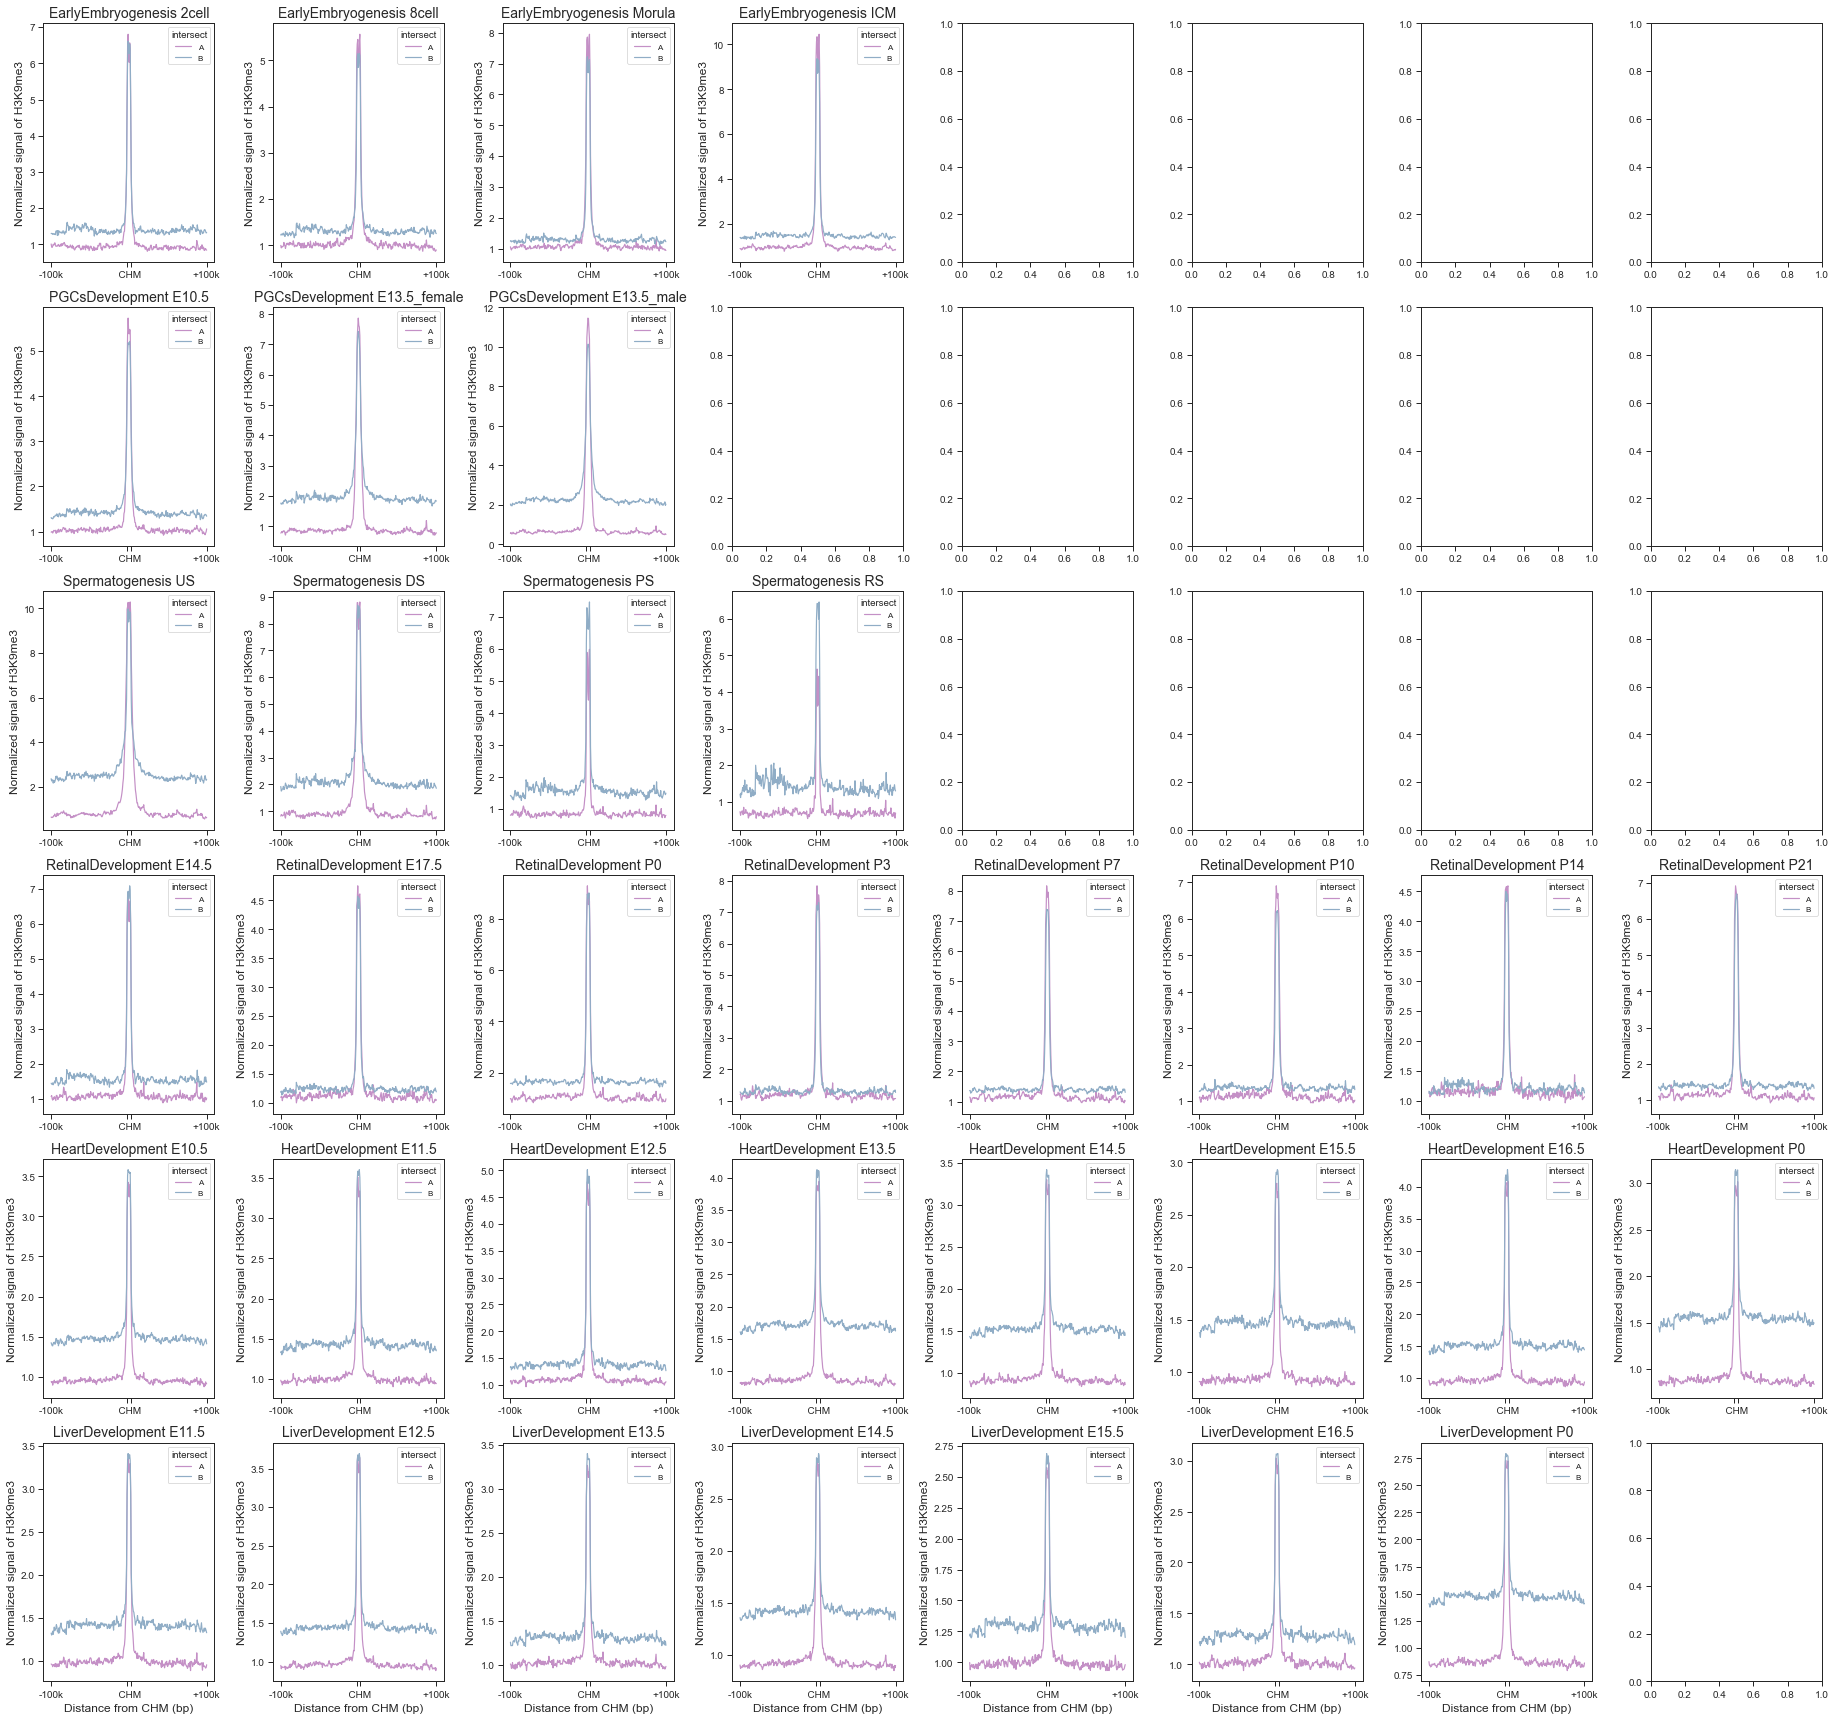

In [14]:
### not used

from scipy.interpolate import make_interp_spline, BSpline
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 8
                         }):
    
#     for span in [10000, 50000, 100000, 500000, 1000000, 2000000] :    
    for span in [50000, 100000] :    
#         for cell_type in ['ES', 'NPC', 'CN'] :
        for cell_type in ['intersect'] :
            fig, axes = plt.subplots(6, 8, figsize=(6.4 * 4, 4.8 * 5), sharey = False, sharex = False, tight_layout = True)  
    #         fig.tight_layout(rect=[0, 0.025, 1, .97])
    #         fig.suptitle(f'A/B compartment data from {cell_type}', size = 15)
    #         for i,label in enumerate([f'{process}_{stage}_H3K9me3' for process in stage_dict.keys() for stage in stage_dict[process]]) :
            for a,process in enumerate(stage_dict.keys()) :
                for b,stage in enumerate(stage_dict[process]) : 
    #                 ax = axes[int(i/6), i%6]
                    ax = axes[a, b]
                    label = f'{process}_{stage}_H3K9me3'
#                     for j,compart in enumerate(['totallyInside_A', 'totallyInside_B']) :
                    for j,compart in enumerate(['overlap_A', 'overlap_B']) :
                        x = signal_AB_concat_dict[span][cell_type][label][compart].columns
                        xnew = np.linspace(x.min(), x.max(), 300) 
                        spl = make_interp_spline(x, signal_AB_concat_dict[span][cell_type][label][compart].mean(), k = 3)
                        signal_smooth = spl(xnew)
        #                 ax.plot(xnew, signal_smooth, label=compart, color=color_dict[label.split('_')[0]][j])
                        ax.plot(xnew, signal_smooth, label=compart, color=colors[j])

#                     if b == (len(stage_dict[process])-1) :
                    h, l = ax.get_legend_handles_labels()
                    ax.legend(h, ['A', 'B'], title=cell_type)

                    ax.set_xticks([-span, 0, 5000, 5000+span])
#                     ax.set_xticklabels([f'-{str(span)[:-3]}k', f'-{str(int(span/2))[:-3]}k', " CHM", "", f"+{str(int(span/2))[:-3]}k", f"+{str(span)[:-3]}k"])
                    ax.set_xticklabels([f'-{str(span)[:-3]}k', "  CHM", "", f"+{str(span)[:-3]}k"])

                    if a == (len(stage_dict.keys()) - 1) :
                        ax.set_xlabel('Distance from CHM (bp)')
                    ax.set_ylabel('Normalized signal of H3K9me3')
                    ax.set_title(f'{process} {stage}')

            fig.savefig(f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make13_line_UniversalCHM_overlap_ABcompart_{cell_type}_{str(span)[:-3]}k_5tissue.pdf', transparent=True)        
